In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sn
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from scipy.signal import hilbert

import json 
import pandas as pd
import numpy as np
import os
import glob

from collections import Counter


### *variables*

In [2]:
num_features = 20
labels = []
derived_samples_list = []
file_names = []
feature_names = [
    "num_iq_samples",
    "amp_mean",
    "amp_std",
    "amp_skew",
    "amp_kurtosis",
    "amp_max",
    "amp_min",
    "amp_25perc",
    "amp_50perc",
    "amp_75perc",
    "psd_mean",
    "psd_std",
    "psd_max",
    "psd_min",
    "spectral_centroid",
    "spectral_bandwidth",
    "spectral_flatness",
    "env_mean",
    "env_std",
    "freq_std"
]


data_dir = '/Volumes/DRIVE 128GB/iqSamples_Ruko_F11_Pro.csv'
drone_csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
print(drone_csv_files)

chunk_size = 10_000 # how many rows to hold in memory at a time
every_n_rows = 1000

# Example: sample windows with 50% overlap
# window_size = 1024 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 1024 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 2048 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
window_size = 4096 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
# window_size = 8192 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
# window_size = 16_384 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)
# window_size = 32_768 # number of iq samples per chunk (window_size=1 is 1 sample, i,q)

# step = 8192
# step = 4096
# step = 2048
# step = 1024
step = 512

skipSVC = False
skipRF = True

[]


### *functions*

In [26]:
# other 
def getLabelFromFilename(filename): 
    filename = filename.lower()
    if "phantom" in filename: return "Phantom"
    elif "ruko_f11_pro" in filename: return "Ruko_F11_Pro"
    elif "ruko_f11_base" in filename: return "Ruko_F11_base"
    elif "mavic_air_2_" in filename: return "Mavic_Air_2"
    elif "mavic_air_2s" in filename: return "Mavic_Air_2S"
    elif "deerc" in filename: return "DeerC_DE2"
    elif "mini_se" in filename: return "Mini_SE"
    elif "holystone_hs100" in filename: return "Holystone_HS100"
    elif "none" in filename: return "None"
    else: return "unkown_label"



def load_iq(f, chunk_size, every_n_rows):
    # The chunking in this algo is so that we can read in large files (156M lines or more). 
    # In order to reduce compution time, we skip n number of rows. 
    result = pd.DataFrame()

    for chunk in pd.read_csv(f, chunksize=chunk_size):
        result = pd.concat([result, chunk.iloc[::every_n_rows, :]], ignore_index=True)

    # print("THE DF:\n", result)
    result = result[['i', 'q']].to_numpy()
    return result



# metric's functions 
def checkForFilename(base_name): 
    ext = ".txt"
    i = 1
    filename = f"{base_name}-{i}{ext}"
    while os.path.exists(filename):
        filename = f"{base_name}-{i}{ext}"
        i += 1
    return filename



def saveMetricsToFile(base_name, perc_accuracy, model): 
    filename = checkForFilename(base_name)
    with open(filename, "w") as f:
        f.write(f"Model: {model}\n")
        f.write(f"Accuracy: {perc_accuracy:.2f}%\n\n")
        f.write("\n")
        f.write(f"Number of samples: {len(labels)}\n")
        f.write("Count\tLabel\n")
        counts = Counter(labels)
        for item, count in counts.items():
            f.write(f"{count}\t{item}\n")
        f.write("\n")
        f.write("Classification Report:\n")
        f.write(f"{cr}\n\n")
        f.write("Confusion Matrix:\n")
        
        f.write(f"{cm}\n")





In [4]:
# for numpy conversion 

def extractStatFeatures(iq_window, num_iq_samples): 
    """
    This exracts the statistical features from an iq_window number of IQ samples. 
    This creates what we're calling a "derived" feature. 
    """
    f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
    # Spectral centroid / bandwidth / flatness:
    spectral_centroid = np.sum(f*Pxx)/np.sum(Pxx)
    spectral_bandwidth = np.sqrt(np.sum(Pxx*(f-spectral_centroid)**2)/np.sum(Pxx))
    spectral_flatness = np.exp(np.mean(np.log(Pxx+1e-12)))/np.mean(Pxx+1e-12)
    # Envelope statistics: use Hilbert transform to get instantaneous amplitude
    envelope = np.abs(hilbert(iq_window))
    env_mean = np.mean(envelope)
    env_std  = np.std(envelope)
    # Instantaneous frequency variance (phase derivative)
    phase = np.angle(iq_window)
    inst_freq = np.diff(phase)
    freq_std = np.std(inst_freq)

    sample = [
        int(num_iq_samples),
        np.mean(np.abs(iq_window)),        # mean amplitude
        np.std(np.abs(iq_window)),         # amplitude std
        skew(np.abs(iq_window)),           # skewness
        kurtosis(np.abs(iq_window)),       # kurtosis
        np.max(np.abs(iq_window)),         # max
        np.min(np.abs(iq_window)),         # min
        np.percentile(np.abs(iq_window),25),
        np.percentile(np.abs(iq_window),50),
        np.percentile(np.abs(iq_window),75),
        np.mean(Pxx), np.std(Pxx), np.max(Pxx), np.min(Pxx),      # PSD stats
        spectral_centroid, spectral_bandwidth, spectral_flatness, # spectral
        env_mean, env_std, freq_std                                  # envelope / freq
    ]
    
    return np.array(sample)




def binaryIQToNumpy(meta_file): 
    data_file = meta_file.replace("meta", "data")
    label = getLabelFromFilename(meta_file)

    print(f"Label: {label}")
    print(f"Converting: \n{meta_file.replace(".sigmf-meta", "")}")

    try:
        with open(meta_file, 'r') as f:
            meta = json.load(f)
    except json.JSONDecodeError:
        print(f"Error: {json.JSONDecodeError}")
        return

    dtype_map = {
        "ri8_le":  np.int8,
        "ri16_le": np.int16,
        "ri32_le": np.int32,
        "rf32_le": np.float32,
        "cf32_le": np.complex64,
        "ci8_le":  np.int8,
        "ci16_le": np.int16,
        "ci32_le": np.int32,
    }
    dtype = dtype_map.get(meta["global"]["core:datatype"], np.int16)

    iq = np.fromfile(data_file, dtype=dtype)

    print(f"Converted {(len(iq) // 2):,} samples to numpy array")
    print(f"After conversion, one IQ sample: {iq[:2]}")
    
    return (iq)




def readInBinDirectoryWithWindows(dir): 
    drone_bin_files = glob.glob(os.path.join(dir, "*.sigmf-meta"))
    iq_files = []
    num_derived_samples_total= 0
    
    # first convert the files into a numpy array 
    for file in drone_bin_files:
        print("--------------------------------------------")
        file_names.append(file)
        iq_samples = binaryIQToNumpy(file)
        iq_files.append(iq_samples)
        num_derived_samples_total += (iq_samples.size // 2) // window_size
    
    # Then create a numpy array of the statistical features from the files
    # The number if IQ samples to consider for each derived sample is the window_size
    # i.e. a window_size of 12 means 12 IQ samples will be used in one derived sample
    derived_samples = np.empty((num_derived_samples_total, num_features))
    for i, iq_file in enumerate(iq_files): 
        n_samps_in_file = (iq_file.size // 2) // window_size
        print("--------------------------------------------")
        drvd_samps = np.empty((n_samps_in_file, num_features))
        for j in range(n_samps_in_file):
            start = j * window_size
            end = start + window_size
            iq_window = iq_file[start:end]
            if len(iq_window) != window_size:
                continue
            drvd_samps[j, :] = extractStatFeatures(iq_window, -1)

        start = i * len(drvd_samps)
        end = start + len(drvd_samps)
        derived_samples[start:end] = drvd_samps
        
    print("--------------------------------------------")
    print(f"Shape of ALL samples: {derived_samples.shape}")
    print(f"One ALL Sample:\n{derived_samples[:1]}")

    return derived_samples




def readInBinDirectoryWithAnnotations(dir): 
    drone_bin_files = glob.glob(os.path.join(dir, "*.sigmf-meta"))
    iq_files = []
    
    # first convert the files into a numpy array 
    for file in drone_bin_files:
        print("--------------------------------------------")
        file_names.append(file)
        iq_files.append(binaryIQToNumpy(file))
    
    # Then create a numpy array of the statistical features from the files
    grabStudioLabelsFromIQFiles(iq_files)
    return np.vstack(derived_samples_list)





def grabStudioLabelsFromIQFiles(iq_files):
    print("--------------------------------------------")
    # num_samps_total = 0 
    samples_per_file = []
    
    # First find the total number of samples (being the derived samples) in our entire dataset 
    for i, iq_file in enumerate(iq_files): 
        with open(file_names[i], "r") as f: 
            meta_file = json.load(f) 
            samples_per_file.append(len(meta_file["annotations"]) * 2 + 1) # *2+1 in order to include the UNannotated segments
            # num_samps_total += samples_per_file[i]
            print(f"Found {len(meta_file["annotations"])} annotations in {getLabelFromFilename(file_names[i])}")
    
    print(f"\nNow extracting the features\n")

    # For each file, extract the annotated and unnotated segments as derived statistical samples
    for i, iq_file in enumerate(iq_files): 
        print("--------------------------------------------")

        with open(file_names[i], "r") as f: 
            annotation_file = json.load(f)
            print(f"Label: {getLabelFromFilename(file_names[i])}")
        
            start = -1 # where to start the segment of interest in the current iq_file
            end = -1 # where to end the segment in the current iq_file
            
            for j, annotation in enumerate(annotation_file["annotations"]):
                # For segments that are NOT annotated: 
                start = end + 1
                end = annotation["core:sample_start"] * 2 - 1
                if end - start > 0: 
                    labels.append("unknown")
                    derived_samples_list.append(extractStatFeatures(iq_file[start:end], (end - start) // 2))
                    
                # for segments that ARE annotated: 
                labels.append(annotation["core:label"])
                start = annotation["core:sample_start"] * 2
                end = start + annotation["core:sample_count"] * 2
                derived_samples_list.append(extractStatFeatures(iq_file[start:end], (end - start) // 2))
    
    print(f"The number of samples found: {len(derived_samples_list)}")
    return np.vstack(derived_samples_list)
    

## Loading Dataset

### *Reading in files*

In [5]:
data_dir = '/Volumes/DRIVE 128GB/'
derived_samples = readInBinDirectoryWithAnnotations(data_dir)

--------------------------------------------
Label: Mavic_Air_2
Converting: 
/Volumes/DRIVE 128GB/2025-10-15-20-59-04_mavic_air_2_5735MHz_chan_0
Converted 15,625,000 samples to numpy array
After conversion, one IQ sample: [-2357  8992]
--------------------------------------------
Label: DeerC_DE2
Converting: 
/Volumes/DRIVE 128GB/2025-10-16-23-27-01_deerc_de22_remote_500ms_2455MHz_chan_0
Converted 15,625,000 samples to numpy array
After conversion, one IQ sample: [ 0 -5]
--------------------------------------------
Label: Holystone_HS100
Converting: 
/Volumes/DRIVE 128GB/2025-10-16-22-16-49_holystone_hs100_500ms_5300MHz_chan_0
Converted 15,625,000 samples to numpy array
After conversion, one IQ sample: [-630 -945]
--------------------------------------------
Found 191 annotations in Mavic_Air_2
Found 52 annotations in DeerC_DE2
Found 76 annotations in Holystone_HS100

Now extracting the features

--------------------------------------------
Label: Mavic_Air_2


/var/folders/3b/9d3900dj0b53yzgc017pbr480000gq/T/ipykernel_27726/2032310975.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 377, using nperseg = 377
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD
/var/folders/3b/9d3900dj0b53yzgc017pbr480000gq/T/ipykernel_27726/2032310975.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 24, using nperseg = 24
  f, Pxx = welch(iq_window, nperseg=1024)  # FFT-based PSD


--------------------------------------------
Label: DeerC_DE2
--------------------------------------------
Label: Holystone_HS100
The number of samples found: 620


### *displaying data*

In [ ]:
print(f"Type of derived samples: {type(derived_samples)}")
print(f"Shape of derived samples: {derived_samples.shape}")
print()
print(f"Type of each sample: {type(derived_samples[0])}")
print(f"Shape of each sample: {derived_samples[0].shape}")
print()
print(f"Type of each feature: {type(derived_samples[0][0])}")
print()

print(f"Num IQ's\tLabel")
for i in range(5): 
    print(f"{int(derived_samples[i][0]):,}", end="\t\t")
    print(f"{labels[i]}")
print()
# print(f"Two samples: \n{derived_samples[:2]}")

print()
print(f"Labels Found:")
print("Count\tLabel")
counts = Counter(labels)
for item, count in counts.items():
    print(f"{count}\t{item}")


Type of derived samples: <class 'numpy.ndarray'>
Shape of derived samples: (620, 20)

Type of each sample: <class 'numpy.ndarray'>
Shape of each sample: (20,)

Type of each feature: <class 'numpy.float64'>

Num IQ's	Label
188		unknown
74,775		Ocusync_2.0_mavic_air_2_DL
29,027		unknown
95,971		Ocusync_2.0_mavic_air_2_DL
29,028		unknown


Labels Found:
Count	Label
301	unknown
107	Ocusync_2.0_mavic_air_2_DL
84	Ocusync_2.0_mavic_air_2_UL
52	DeerC_DE22_Uplink
76	HS100_Downlink


In [7]:
# Display the table 

if False: 
    print("  ", end="")
    print(" ".join(f"{x:>29}" for x in feature_names))

    np.set_printoptions(threshold=np.inf, linewidth=1000, suppress=True)
    print(np.array2string(
        derived_samples,
        formatter={'float_kind': '                     {:8.0f}'.format},
        max_line_width=12000  # increase line width
    ))

## Random Forest Classifer 

### *preprocessing*

In [8]:
X = derived_samples
y = np.array(labels)

print(f"Num samples: {X.shape}")
print(f"Num labels: {y.size}")
print(f"Number of features: {num_features}")

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Num samples: (620, 20)
Num labels: 620
Number of features: 20


### *Training, fitting & predicting*

I need to figure out how to use the random forest classifier for this. 

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

### *Metrics*

In [28]:


accuracy = accuracy_score(y_test, y_pred)
perc_accuracy = accuracy * 100
print(f"Accuracy: {perc_accuracy:.2f}%")
print()
print(f"Number of samples: {len(labels)}")
print("Count\tLabel")
counts = Counter(labels)
for item, count in counts.items():
    print(f"{count}\t{item}")
print()

cr = classification_report(y_test, y_pred, target_names=le.classes_)
cm = confusion_matrix(y_test, y_pred)
print(cr)
print()
print(cm)
print()

saveMetricsToFile('svc_metrics', perc_accuracy, "Random Forest")

Accuracy: 99.19%

Number of samples: 620
Count	Label
301	unknown
107	Ocusync_2.0_mavic_air_2_DL
84	Ocusync_2.0_mavic_air_2_UL
52	DeerC_DE22_Uplink
76	HS100_Downlink

                            precision    recall  f1-score   support

         DeerC_DE22_Uplink       1.00      1.00      1.00        10
            HS100_Downlink       1.00      1.00      1.00        15
Ocusync_2.0_mavic_air_2_DL       1.00      1.00      1.00        22
Ocusync_2.0_mavic_air_2_UL       0.94      1.00      0.97        17
                   unknown       1.00      0.98      0.99        60

                  accuracy                           0.99       124
                 macro avg       0.99      1.00      0.99       124
              weighted avg       0.99      0.99      0.99       124


[[10  0  0  0  0]
 [ 0 15  0  0  0]
 [ 0  0 22  0  0]
 [ 0  0  0 17  0]
 [ 0  0  0  1 59]]



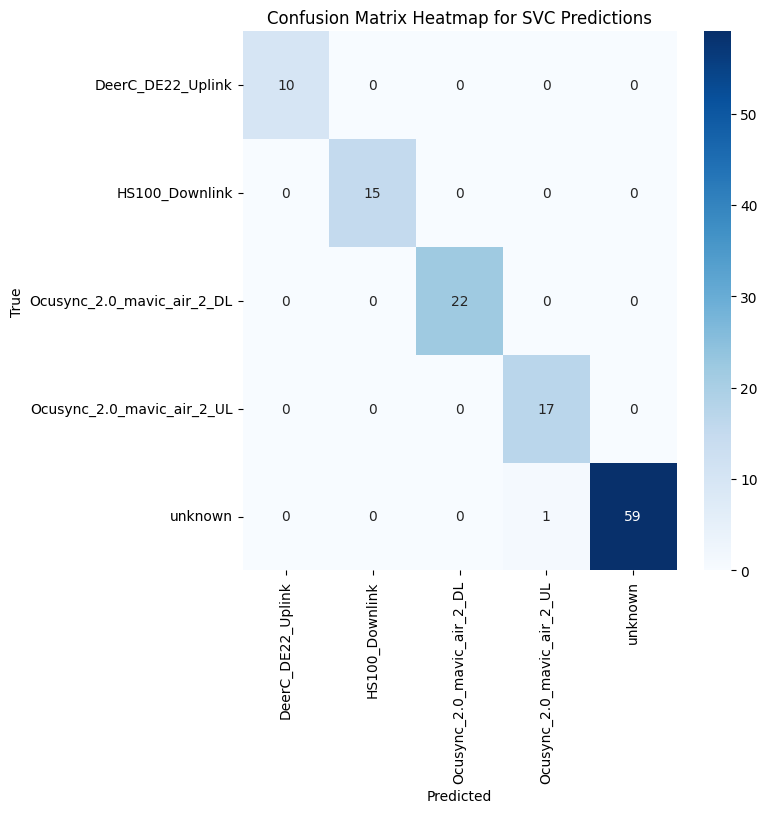

In [15]:
# Create a heatmap of the confusion matrix

plt.figure(figsize=(7, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))

# Labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap for SVC Predictions')

plt.show()
